# Logistic Regression

## Exploratory Data Analysis

In [198]:
import numpy as nop
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

In [199]:
train = pd.read_csv("./filez/titanic_train.csv")
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


<Axes: xlabel='Survived', ylabel='count'>

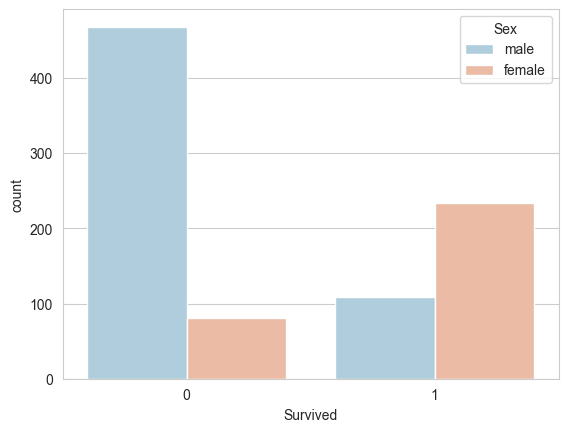

In [200]:
# show survivors by sex
# -> men were not likely to survive
sns.countplot(x="Survived", data=train, hue="Sex", palette="RdBu_r")

<Axes: xlabel='Survived', ylabel='count'>

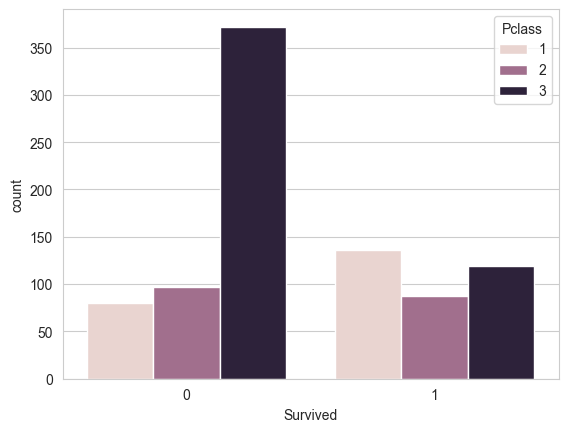

In [201]:
# show survivors by class
# -> most people that didn't survive was from 3rd class
sns.countplot(x="Survived", data=train, hue="Pclass")

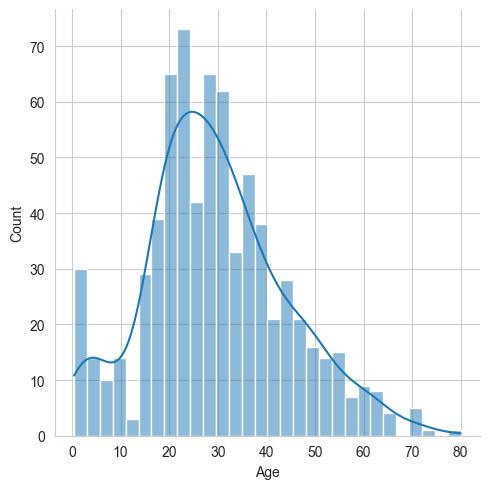

In [202]:
# show passangers by age
# -> quite a few children, but then normal distribution
sns.displot(data=train["Age"].dropna(), kde=True, bins=30)

<Axes: xlabel='SibSp', ylabel='count'>

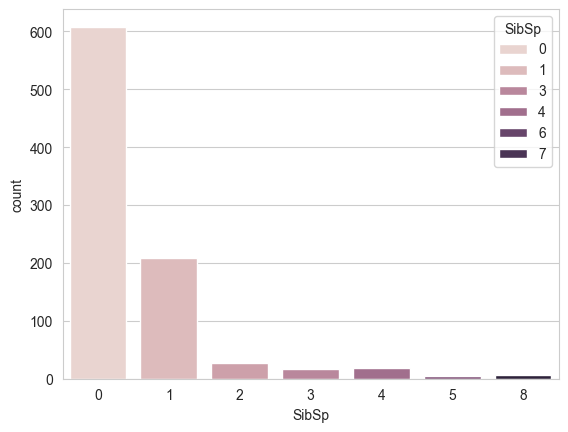

In [203]:
# show relatives
# -> most people didn't have either a children or spouse.
# Probably most men in 3rd class, and then couples
sns.countplot(data=train, x="SibSp", hue="SibSp")

<Axes: >

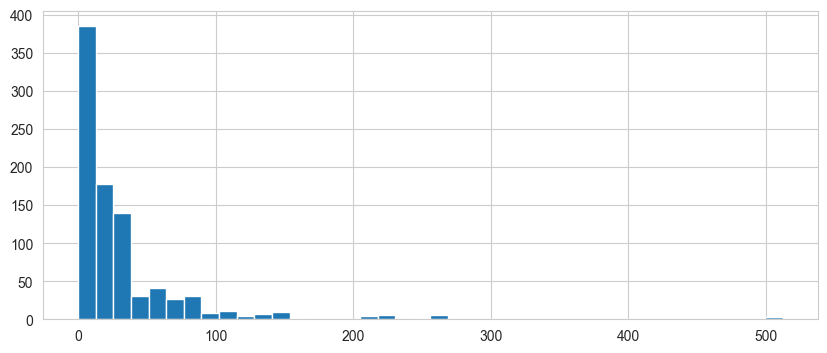

In [204]:
# show distribution of fare
# -> most were from the cheapest class (3rd)
train["Fare"].hist(bins=40, figsize=(10, 4))

## Data Cleaning
Dealing with missing values

<Axes: >

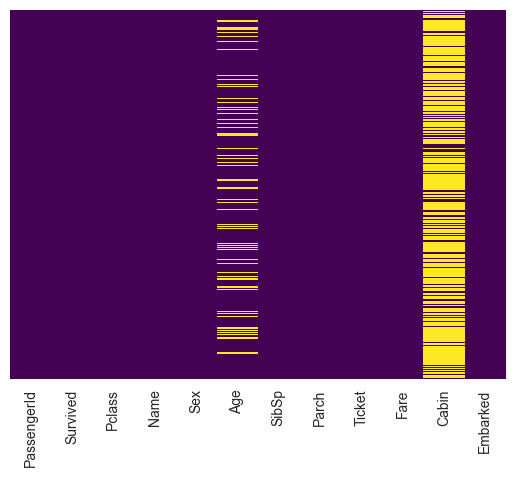

In [205]:
# show null values in a heatmap
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap="viridis")

<Axes: xlabel='Pclass', ylabel='Age'>

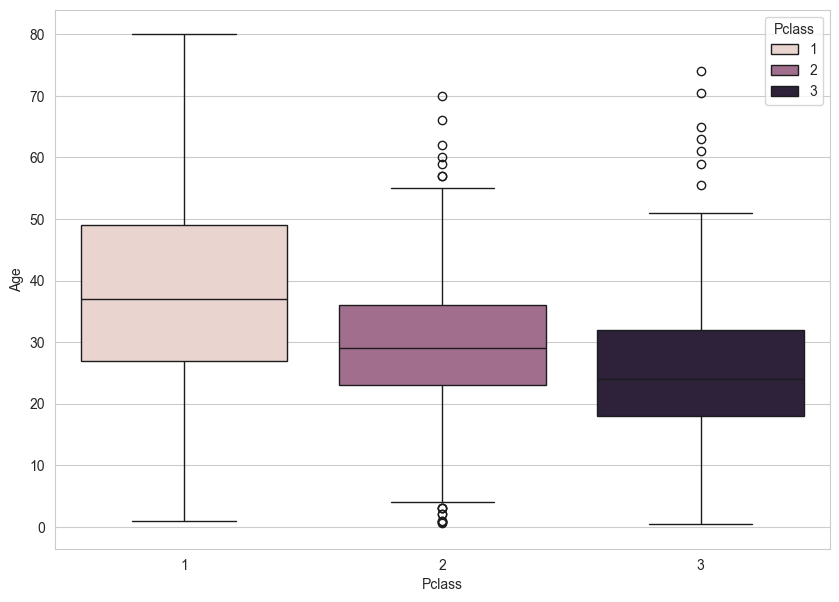

In [206]:
# show age by class
# -> the older person, the higher class (3->2->1), so we could impute (fill)
# the age based off the class
plt.figure(figsize=(10, 7))
sns.boxplot(data=train, x="Pclass", y="Age", hue="Pclass")

In [207]:
def impute_age(cols):
    Age = cols.iloc[0]
    Pclass = cols.iloc[1]
    if pd.isnull(Age):
        if Pclass == 1:
            return 37  # avg value from 1st class
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

In [208]:
train["Age"] = train[["Age", "Pclass"]].apply(
    impute_age, axis=1
)  # axis:1 to apply to columns

<Axes: >

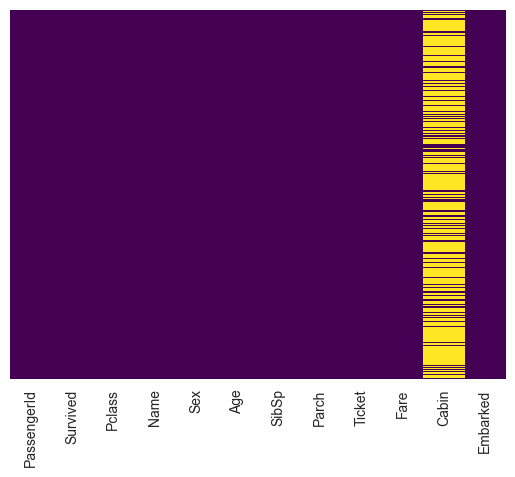

In [209]:
# show null values in a heatmap
# -> no nulls for age
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap="viridis")

In [210]:
# -> so many missing points for cabin that doesn't seem to be useful
train.drop("Cabin", axis=1, inplace=True)
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C


## Categorical Features

In [211]:
# Columns `Sex` and `Embarked` are strings, so we need to create
# dummy variables on them for the machine learning

# This would create a multicollinearity issue, because a bunch of
# columns would be perfect predictors of another column.
pd.get_dummies(train["Sex"])

,female,male
0,False,True
1,True,False
2,True,False
3,True,False
4,False,True
...,...,...
886,False,True
887,True,False
888,True,False
889,False,True


In [212]:
sex = pd.get_dummies(train["Sex"], drop_first=True)
sex.head(3)

,male
0,True
1,False
2,False


In [213]:
embark = pd.get_dummies(train["Embarked"], drop_first=True)
embark.head(3)

,Q,S
0,False,True
1,False,False
2,False,True


In [214]:
# In this case, it's not a "perfect predictor", so we need to get both values.
# Then, we can add these new columns to the df
train = pd.concat([train, sex, embark], axis=1)
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,True,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,False,False,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,False,False,True


In [215]:
# drop str columns we won't need
train.drop(["Sex", "Embarked", "Name", "Ticket"], axis=1, inplace=True)
# drop int columns we won't need
train.drop('PassengerId', axis=1, inplace=True)
train.head(3)

# Open question: Pclass could have also been treated as dummy
# -> category vs. continuous variable?

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,True,False,True
1,1,1,38.0,1,0,71.2833,False,False,False
2,1,3,26.0,0,0,7.9250,False,False,True


## Create the Model

In [216]:
# @dev: we'll consider the train csv as the full dataset, although
#       there's a test data in the original dataset
X = train.drop("Survived", axis=1)
y = train["Survived"]

In [217]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=101
)


In [218]:
from sklearn.linear_model import LogisticRegression
# using max_iter=1000 to avoid "STOP: TOTAL NO. of ITERATIONS REACHED LIMIT." warning
# alternatively, scale the data 
logmodel = LogisticRegression(max_iter=1000)

In [219]:
# train the model
logmodel.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [220]:
predictions = logmodel.predict(X_test)

## Evaluate the Model


In [221]:
# shows precision/accuracy of the model
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       154
           1       0.79      0.67      0.72       114

    accuracy                           0.78       268
   macro avg       0.79      0.77      0.77       268
weighted avg       0.78      0.78      0.78       268



**Precision**: accuracy of the positive predictions. For example, when the model predicts if passanger survived (1), it is correct about 79% of the time.

**Recall**: indicates the ability of the model to find all the relevant cases within a dataset. For survived (1), the model correctly identified 67% of all actual survived instances.

**F1-score**: weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. It is a balance between precision and recall. For survived (1), the F1-score is 0.72, which is lower than the F1-score for not survived (0.82), suggesting that the model is better at predicting not survived (0) instances.

**Support**: number of actual occurrences of the class in the specified dataset. Here, there are 154 instances of not survived (0) and 114 instances of survived (1) in the test set.

**Accuracy**: proportion of the total number of predictions that were correct. It is 78% here, which is relatively high.

**Macro avg**: average precision, recall, and F1-score between classes, treating all classes equally.

**Weighted avg**: class imbalance by weighting the average based on the number of instances in each class.


In [222]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, predictions))
"""
[[True Negative  False Positive]
 [False Negative True Positive]]
"""

[[134  20]
 [ 38  76]]


'\n[[True Negative  False Positive]\n [False Negative True Positive]]\n'

- 134 True Negatives: The model correctly predicted that 134 passengers did not survive.
- 20 False Positives: The model incorrectly predicted that 20 passengers survived when they did not.
- 38 False Negatives: The model incorrectly predicted that 38 passengers did not survive when they did.
- 76 True Positives: The model correctly predicted that 76 passengers survived.